Loading the Fashion-MNIST data.

In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def load_data(filename, dims):
    with gzip.open(filename, "rb") as infile:
        # consume magic number
        infile.read(4)
        # consume dimensions data
        infile.read(4 * len(dims))

        return np.frombuffer(infile.read(np.prod(dims)), dtype=np.uint8).reshape(dims)

# training data
train_images = load_data("data/train-images-idx3-ubyte.gz", [60000, 28, 28])
train_labels = load_data("data/train-labels-idx1-ubyte.gz", [60000])

# testing data
test_images = load_data("data/t10k-images-idx3-ubyte.gz", [10000, 28, 28])
test_labels = load_data("data/t10k-labels-idx1-ubyte.gz", [10000])

Converting the images to floating point data and rescaling them between 0 and 1. Creating one-hot vectors from the labels.

In [2]:
train_x = train_images.astype(np.float) / 255
train_y = np.zeros((60000, 10))
train_y[np.arange(60000),train_labels] = 1

test_x = test_images.astype(np.float) / 255
test_y = np.zeros((10000, 10))
test_y[np.arange(10000),test_labels] = 1

Creating 2D UMAP and PCA embeddings for visualizing the data.

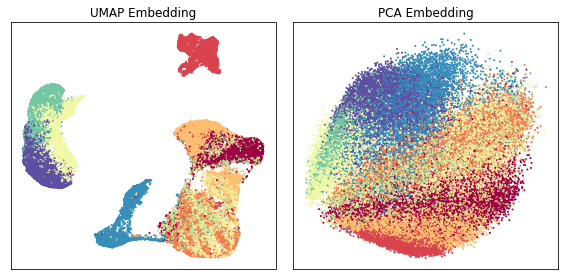

In [3]:
import os
import pickle
from umap import UMAP
from sklearn.decomposition import PCA


def create_embeddings(data, ignore_cache=False):
    umap_dir = "cache/umap.pickle"
    pca_dir = "cache/pca.pickle"

    if not os.path.isfile(umap_dir) or ignore_cache:
        umap_reducer = UMAP(random_state=42).fit(data)
        pickle.dump(umap_reducer, open(umap_dir, "wb"))
    else:
        umap_reducer = pickle.load(open(umap_dir, "rb"))

    if not os.path.isfile(pca_dir) or ignore_cache:
        pca_reducer = PCA(n_components=2, random_state=42).fit(data)
        pickle.dump(pca_reducer, open(pca_dir, "wb"))
    else:
        pca_reducer = pickle.load(open(pca_dir, "rb"))
        
    return umap_reducer, pca_reducer


umap_reducer, pca_reducer = create_embeddings(train_x.reshape(-1, 784), ignore_cache=False)
umap_data = umap_reducer.transform(train_x.reshape(-1, 784))
pca_data = pca_reducer.transform(train_x.reshape(-1, 784))


def plot_embeddings():
    fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(8,4))
    axes[0].scatter(umap_data[:,0], umap_data[:,1], s=1, c=train_labels, cmap='Spectral')
    axes[0].set_title("UMAP Embedding")

    axes[1].scatter(pca_data[:,0], pca_data[:,1], s=1, c=train_labels, cmap='Spectral')
    axes[1].set_title("PCA Embedding")
    plt.setp(axes, xticks=[], yticks=[])
    plt.tight_layout()
    
plot_embeddings()

Helper function for plotting the movement of clusters during training.

In [4]:
def plot_cluster_movement(ax, data, init, current):
    change = current - init
    
    ax.scatter(data[:,0], data[:,1], s=1, c=train_labels, cmap='Spectral')
    s1 = ax.scatter(init[:,0], init[:,1], s=100, c="k", marker="^")
    s2 = ax.scatter(current[:,0], current[:,1], s=100, c="r", marker="^")
    
    for i in range(change.shape[0]):
        ax.arrow(init[i,0], init[i,1], change[i,0], change[i,1])
    ax.legend([s1, s2], ["Before Training", "After Training"])

Training the model with a random initialization. Plot the cluster movement over the course of training. Plot the training and test accuracy over the course of training.

Using TensorFlow backend.
W0218 14:11:52.400527 140265343399744 deprecation.py:323] From /home/ryan-desktop/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 54us/step - loss: 0.3241 - categorical_accuracy: 0.5156 - val_loss: 0.2350 - val_categorical_accuracy: 0.7173
Epoch 2/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.2017 - categorical_accuracy: 0.7655 - val_loss: 0.1754 - val_categorical_accuracy: 0.7930
Epoch 3/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.1559 - categorical_accuracy: 0.8119 - val_loss: 0.1421 - val_categorical_accuracy: 0.8065
Epoch 4/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.1278 - categorical_accuracy: 0.8280 - val_loss: 0.1205 - val_categorical_accuracy: 0.8171
Epoch 5/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.1093 - categorical_accuracy: 0.8399 - val_loss: 0.1068 - val_categorical_accuracy: 0.8292
Epoch 6/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.0973 - categor

60000/60000 [==============================] - 3s 46us/step - loss: 0.0584 - categorical_accuracy: 0.8887 - val_loss: 0.0808 - val_categorical_accuracy: 0.8507
Epoch 49/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.0583 - categorical_accuracy: 0.8881 - val_loss: 0.0812 - val_categorical_accuracy: 0.8487
Epoch 50/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.0581 - categorical_accuracy: 0.8891 - val_loss: 0.0816 - val_categorical_accuracy: 0.8485


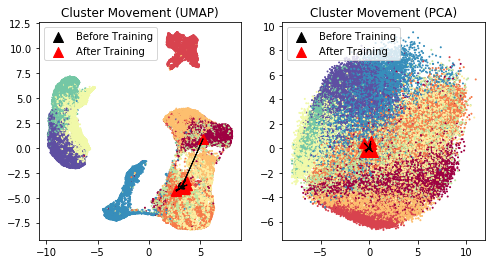

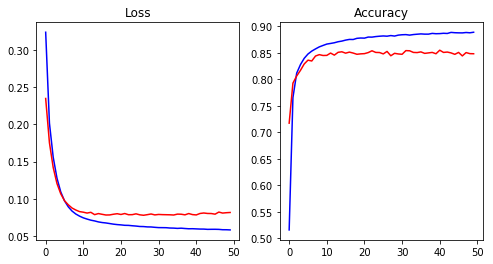

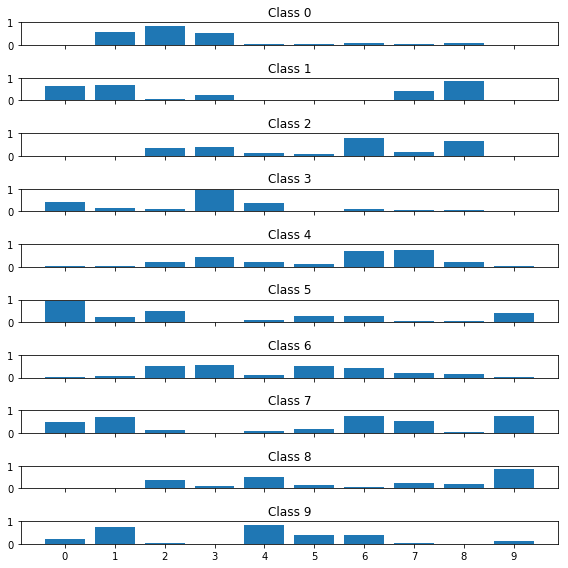

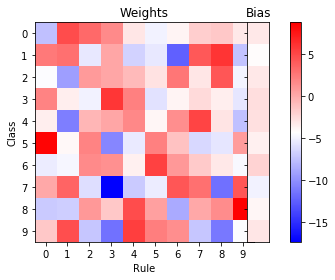

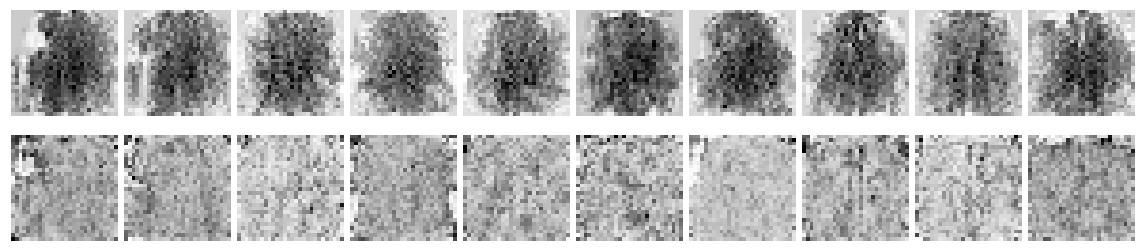

In [5]:
import keras
import keras.layers as layers
import keras.models as models
import keras.backend as K
from model import GaussMembership, normalized_product_fn


def train_random_initialization():
    # create the model
    model = keras.Sequential([
        layers.Reshape((784,), input_shape=(28,28)),
        GaussMembership(10),
        layers.Lambda(lambda x: normalized_product_fn(x)),
        layers.Dense(10, activation="sigmoid"),])
    
    # set weights randomly
    model.layers[1].set_weights((
        # multiplying the by the mean is a way to ensure that the centers occupy the same subset of the
        # feature space as the input data
        np.random.normal(1., 0.1, size=(10,784)) * np.mean(train_x.reshape(-1, 784), axis=0, keepdims=True),
        np.random.normal(1., 0.1, size=(10,784))))
    
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[keras.metrics.categorical_accuracy])
    
    init_mu = model.layers[1].get_weights()[0]

    # train the model
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=64,
        epochs=50,
        validation_data=(test_x, test_y),
        verbose=1,
        shuffle=True)
    
    final_mu, final_sigma = model.layers[1].get_weights()
    
    # plot the cluster movement
    fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(8,4))
    axes[0].set_title("Cluster Movement (UMAP)")
    plot_cluster_movement(
        axes[0], umap_data,
        umap_reducer.transform(init_mu), 
        umap_reducer.transform(final_mu))

    axes[1].set_title("Cluster Movement (PCA)")
    plot_cluster_movement(
        axes[1], pca_data,
        pca_reducer.transform(init_mu), 
        pca_reducer.transform(final_mu))
    
    # plot the loss and accuracy
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), squeeze=True)
    axes[0].set_title("Loss")
    axes[0].plot(history.history["loss"], c="b")
    axes[0].plot(history.history["val_loss"], c="r")

    axes[1].set_title("Accuracy")
    #axes[1].set_ylim((0.8, 1))
    axes[1].plot(history.history["categorical_accuracy"], c="b")
    axes[1].plot(history.history["val_categorical_accuracy"], c="r")
    
    # plot mean firing strength for class
    fstrength_fn = K.function(model.inputs, [model.layers[2].output])
    fig, axes = plt.subplots(10, 1, squeeze=True, figsize=(8,8), sharex=True)
    for i in range(10):
        fstrength = fstrength_fn([train_x[train_labels == i]])[0]
        axes[i].set_title("Class {}".format(i))
        axes[i].bar(np.arange(10), np.mean(fstrength, axis=0))
        
    plt.setp(axes, xticks=np.arange(10), yticks=[0,1])
    plt.tight_layout()
    
    # plot weights and bias
    kernel, bias = model.layers[3].get_weights()
    fig, (ax0, ax1) = plt.subplots(
        1, 2, sharey=True, squeeze=True, gridspec_kw={'width_ratios':[9, 1]})

    im0 = ax0.imshow(kernel.T, cmap="bwr")
    ax0.set_title("Weights")
    ax0.set_ylabel("Class")
    ax0.set_xlabel("Rule")
    ax0.set_yticks(np.arange(10))
    ax0.set_xticks(np.arange(10))

    ax1.imshow(bias.reshape(10,1), cmap="bwr", vmin=np.min(kernel), vmax=np.max(kernel))
    ax1.set_title("Bias")
    ax1.set_xticks([])

    plt.tight_layout(w_pad=0.1)
    fig.colorbar(im0, ax=[ax0, ax1])
    
    # plot mu and sigma parameters and mean membership values
    fig, axes = plt.subplots(2, 10, figsize=(16,4))
    for i in range(10):
        axes[0][i].imshow(final_mu[i,:].reshape(28, 28), cmap="Greys", interpolation="none")
        axes[1][i].imshow(final_sigma[i,:].reshape(28, 28), cmap="Greys", interpolation="none")

    plt.setp(axes, xticks=[], yticks=[], frame_on=False)
    plt.tight_layout(h_pad=0, w_pad=0)
    
    
train_random_initialization()

The clusters still do not appear to fit the data in the projections. This has happened in all experiments despite the network being able to fit the data quite well. 

Inspecting the parameters shows that the network has not learned the classes in the way that was expected. The parameters appear as random shapes when plotted as images. This is why UMAP can't project them properly (they are likely not on the manifold).

Next, the model is trained using the FCM initialization.

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 52us/step - loss: 0.4541 - categorical_accuracy: 0.1195 - val_loss: 0.3350 - val_categorical_accuracy: 0.1743
Epoch 2/50
60000/60000 [==============================] - 3s 48us/step - loss: 0.3125 - categorical_accuracy: 0.2826 - val_loss: 0.2893 - val_categorical_accuracy: 0.3929
Epoch 3/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.2539 - categorical_accuracy: 0.5319 - val_loss: 0.2095 - val_categorical_accuracy: 0.6846
Epoch 4/50
60000/60000 [==============================] - 3s 48us/step - loss: 0.1716 - categorical_accuracy: 0.7576 - val_loss: 0.1499 - val_categorical_accuracy: 0.7826
Epoch 5/50
60000/60000 [==============================] - 3s 48us/step - loss: 0.1345 - categorical_accuracy: 0.7958 - val_loss: 0.1283 - val_categorical_accuracy: 0.7903
Epoch 6/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.1165 - categor

60000/60000 [==============================] - 3s 50us/step - loss: 0.0585 - categorical_accuracy: 0.8951 - val_loss: 0.0803 - val_categorical_accuracy: 0.8546
Epoch 49/50
60000/60000 [==============================] - 3s 49us/step - loss: 0.0582 - categorical_accuracy: 0.8960 - val_loss: 0.0805 - val_categorical_accuracy: 0.8539
Epoch 50/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.0582 - categorical_accuracy: 0.8963 - val_loss: 0.0796 - val_categorical_accuracy: 0.8542


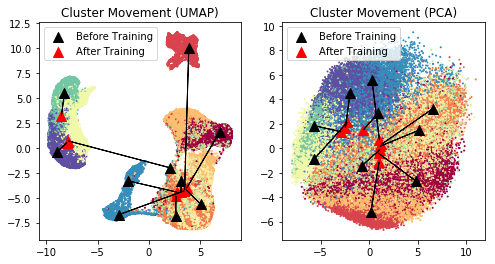

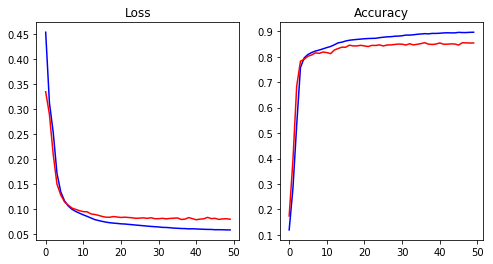

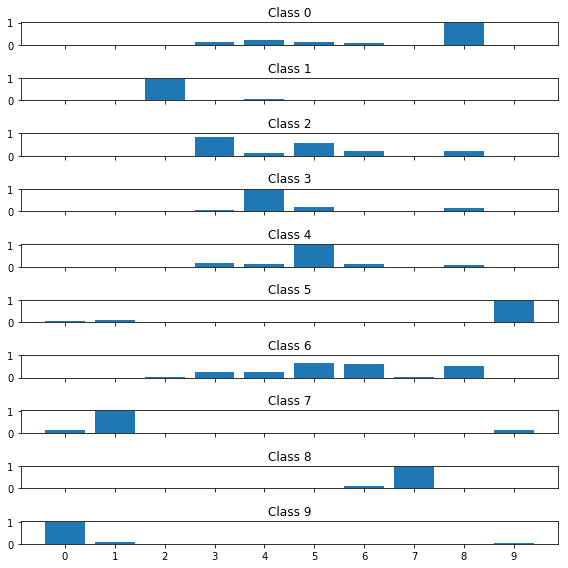

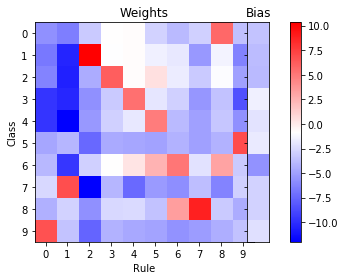

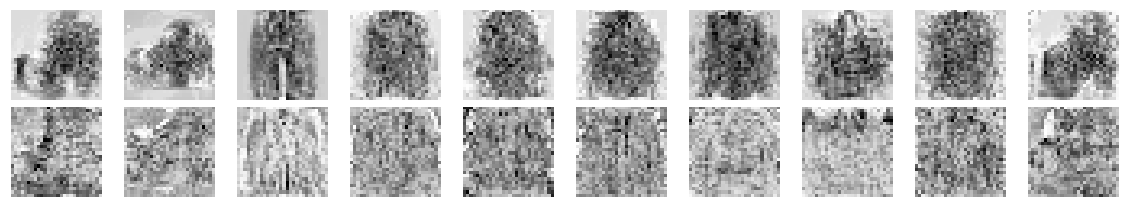

In [6]:
import skfuzzy as skf


def train_fcm_initialization():
    # create the model
    model = keras.Sequential([
        layers.Reshape((784,), input_shape=(28,28)),
        GaussMembership(10),
        layers.Lambda(lambda x: normalized_product_fn(x)),
        layers.Dense(10, activation="sigmoid"),])
    
    init_mu, memberships, u0, d, jm, p, fpc = skf.cmeans(
        train_x.reshape(-1, 784).T, 10, 1.1, 1e-8, 1000, seed=0)
    
    # set weights with fcm
    model.layers[1].set_weights((
        init_mu,
        np.random.normal(1., 0.1, size=(10,784))))
    
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[keras.metrics.categorical_accuracy])

    # train the model
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=64,
        epochs=50,
        validation_data=(test_x, test_y),
        verbose=1,
        shuffle=True)
    
    final_mu, final_sigma = model.layers[1].get_weights()
    
    # plot the cluster movement
    fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(8,4))
    axes[0].set_title("Cluster Movement (UMAP)")
    plot_cluster_movement(
        axes[0], umap_data,
        umap_reducer.transform(init_mu), 
        umap_reducer.transform(final_mu))

    axes[1].set_title("Cluster Movement (PCA)")
    plot_cluster_movement(
        axes[1], pca_data,
        pca_reducer.transform(init_mu), 
        pca_reducer.transform(final_mu))
    
    # plot the loss and accuracy
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), squeeze=True)
    axes[0].set_title("Loss")
    axes[0].plot(history.history["loss"], c="b")
    axes[0].plot(history.history["val_loss"], c="r")

    axes[1].set_title("Accuracy")
    #axes[1].set_ylim((0.8, 1))
    axes[1].plot(history.history["categorical_accuracy"], c="b")
    axes[1].plot(history.history["val_categorical_accuracy"], c="r")
    
        # plot mean firing strength for class
    fstrength_fn = K.function(model.inputs, [model.layers[2].output])
    fig, axes = plt.subplots(10, 1, squeeze=True, figsize=(8,8), sharex=True)
    for i in range(10):
        fstrength = fstrength_fn([train_x[train_labels == i]])[0]
        axes[i].set_title("Class {}".format(i))
        axes[i].bar(np.arange(10), np.mean(fstrength, axis=0))
        
    plt.setp(axes, xticks=np.arange(10), yticks=[0,1])
    plt.tight_layout()
    
    # plot weights and bias
    kernel, bias = model.layers[3].get_weights()
    fig, (ax0, ax1) = plt.subplots(
        1, 2, sharey=True, squeeze=True, gridspec_kw={'width_ratios':[9, 1]})

    im0 = ax0.imshow(kernel.T, cmap="bwr")
    ax0.set_title("Weights")
    ax0.set_ylabel("Class")
    ax0.set_xlabel("Rule")
    ax0.set_yticks(np.arange(10))
    ax0.set_xticks(np.arange(10))

    ax1.imshow(bias.reshape(10,1), cmap="bwr", vmin=np.min(kernel), vmax=np.max(kernel))
    ax1.set_title("Bias")
    ax1.set_xticks([])

    plt.tight_layout(w_pad=0.1)
    fig.colorbar(im0, ax=[ax0, ax1])
    
    # plot mu and sigma parameters
    fig, axes = plt.subplots(2, 10, figsize=(16,3))
    for i in range(10):
        axes[0][i].imshow(final_mu[i,:].reshape(28, 28), cmap="Greys", interpolation="none")
        axes[1][i].imshow(final_sigma[i,:].reshape(28, 28), cmap="Greys", interpolation="none")

    plt.setp(axes, xticks=[], yticks=[], frame_on=False)
    plt.tight_layout(h_pad=0, w_pad=0)
    
    
train_fcm_initialization()

When initialized using FCM, the clusters start in more appropriate locations but move towards the center of dataset. Even though the clusters appear to be in better locations, the performance slightly worse than the random initialization.

Additionally, the parameters form slightly better images but for most part still appear as random blobs.

The next step is to create a convolutional neural network for Fashion MNIST.

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 84us/step - loss: 0.4831 - categorical_accuracy: 0.8264 - val_loss: 0.3717 - val_categorical_accuracy: 0.8623
Epoch 2/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.3167 - categorical_accuracy: 0.8843 - val_loss: 0.3358 - val_categorical_accuracy: 0.8755
Epoch 3/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.2727 - categorical_accuracy: 0.8980 - val_loss: 0.3007 - val_categorical_accuracy: 0.8902
Epoch 4/10
60000/60000 [==============================] - 4s 69us/step - loss: 0.2440 - categorical_accuracy: 0.9093 - val_loss: 0.2937 - val_categorical_accuracy: 0.8959
Epoch 5/10
60000/60000 [==============================] - 4s 68us/step - loss: 0.2179 - categorical_accuracy: 0.9183 - val_loss: 0.2755 - val_categorical_accuracy: 0.9005
Epoch 6/10
60000/60000 [==============================] - 4s 67us/step - loss: 0.1943 - categor

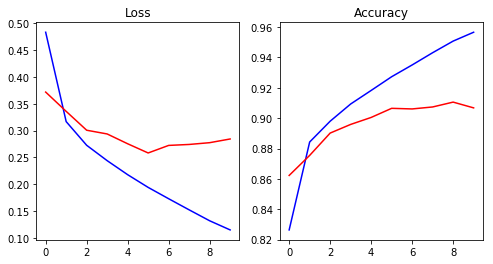

In [7]:
def train_cnn():
    model = keras.Sequential([
        layers.Reshape((28,28,1), input_shape=(28,28)),
        layers.Conv2D(16, (3, 3), strides=(2,2), padding="same", activation="relu"),
        layers.Conv2D(32, (3, 3), strides=(2,2), padding="same", activation="relu"),
        layers.Conv2D(64, (3, 3), strides=(2,2), padding="same", activation="relu"),
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ])
    
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=[keras.metrics.categorical_accuracy])

    # train the model
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=64,
        epochs=10,
        validation_data=(test_x, test_y),
        verbose=1,
        shuffle=True)
    
    # plot the loss and accuracy
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), squeeze=True)
    axes[0].set_title("Loss")
    axes[0].plot(history.history["loss"], c="b")
    axes[0].plot(history.history["val_loss"], c="r")

    axes[1].set_title("Accuracy")
    axes[1].plot(history.history["categorical_accuracy"], c="b")
    axes[1].plot(history.history["val_categorical_accuracy"], c="r")


train_cnn()

Beyond 10 epochs the model began to overfit so training was stopped there. The model was able to achieve an accuracy of about 91.5%.

Next, the hybrid model is trained and compared to the regular CNN.

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 90us/step - loss: 0.3524 - categorical_accuracy: 0.3075 - val_loss: 0.2404 - val_categorical_accuracy: 0.7344
Epoch 2/20
60000/60000 [==============================] - 5s 79us/step - loss: 0.1960 - categorical_accuracy: 0.8060 - val_loss: 0.1605 - val_categorical_accuracy: 0.8273
Epoch 3/20
60000/60000 [==============================] - 5s 77us/step - loss: 0.1349 - categorical_accuracy: 0.8522 - val_loss: 0.1171 - val_categorical_accuracy: 0.8546
Epoch 4/20
60000/60000 [==============================] - 5s 77us/step - loss: 0.1013 - categorical_accuracy: 0.8744 - val_loss: 0.0925 - val_categorical_accuracy: 0.8730
Epoch 5/20
60000/60000 [==============================] - 5s 75us/step - loss: 0.0813 - categorical_accuracy: 0.8874 - val_loss: 0.0784 - val_categorical_accuracy: 0.8842
Epoch 6/20
60000/60000 [==============================] - 5s 76us/step - loss: 0.0682 - categor

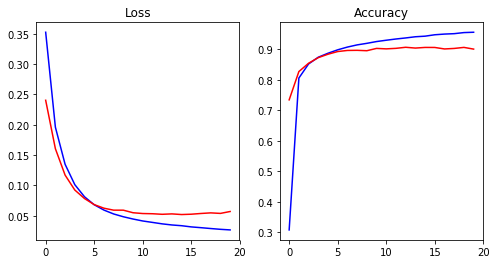

In [8]:
def train_hybrid():
    model = keras.Sequential([
        layers.Reshape((28,28,1), input_shape=(28,28)),
        layers.Conv2D(16, (3, 3), strides=(2,2), padding="same", activation="relu"),
        layers.Conv2D(32, (3, 3), strides=(2,2), padding="same", activation="relu"),
        layers.Conv2D(64, (3, 3), strides=(2,2), padding="same", activation="relu"),
        layers.Flatten(),
        GaussMembership(10),
        layers.Lambda(lambda x: normalized_product_fn(x)),
        layers.Dense(10, activation="sigmoid"),
    ])
    
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[keras.metrics.categorical_accuracy])

    # train the model
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=64,
        epochs=20,
        validation_data=(test_x, test_y),
        verbose=1,
        shuffle=True)
    
    # plot the loss and accuracy
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), squeeze=True)
    axes[0].set_title("Loss")
    axes[0].plot(history.history["loss"], c="b")
    axes[0].plot(history.history["val_loss"], c="r")

    axes[1].set_title("Accuracy")
    axes[1].plot(history.history["categorical_accuracy"], c="b")
    axes[1].plot(history.history["val_categorical_accuracy"], c="r")


train_hybrid()

The model took longer to train than the regular CNN, likely due to the small gradients in the membership layer. In 20 epochs it was able to achieve approx 91.0% on the out of sample validation data.